## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

In [ ]:
import sys
sys.path.append('..')

from src.stratego_utils import read_setups
from src.generators import LSTMGenerator
from src.training import train
from src.plotting import plot_setups, plot_setup_generation
from src.evaluation import plot_per_square_distributions, compute_nearest_neighbors
from src.evaluation import LSTMClassifier, create_classification_dataset, binary_log_loss_from_logits

## Load model and sample setups

In [ ]:
SEED = 42
MODEL_PATH = "../models/lstm_generator.pth"
DATA_PATH = "../data/setups.csv"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model_info = torch.load(MODEL_PATH, map_location=device)
model = LSTMGenerator(**loaded_model_info['model_params'])
model.load_state_dict(loaded_model_info['model_state_dict'])
model = model.to(device)

In [ ]:
real_setups = read_setups(DATA_PATH)
generated_setups, distributions = model.generate_setups(num_setups=len(real_setups), seed=SEED)

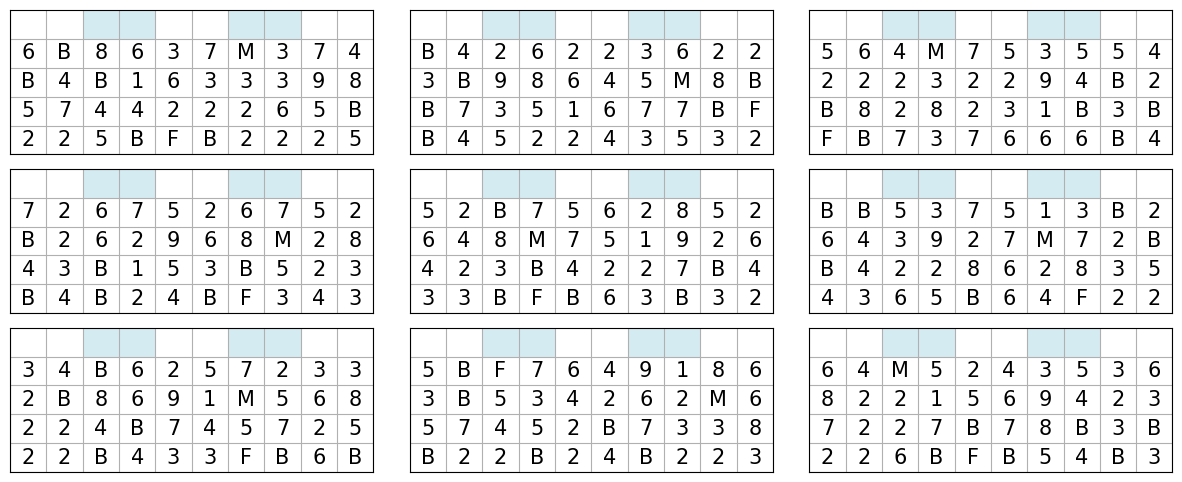

In [ ]:
plot_setups(generated_setups[:9], num_columns=3, tile_size=0.5)

## Compare piece distributions for each square between generated and real setups

In [ ]:
real_setups_df = pd.DataFrame(real_setups)
generated_setups_df = pd.DataFrame(generated_setups)

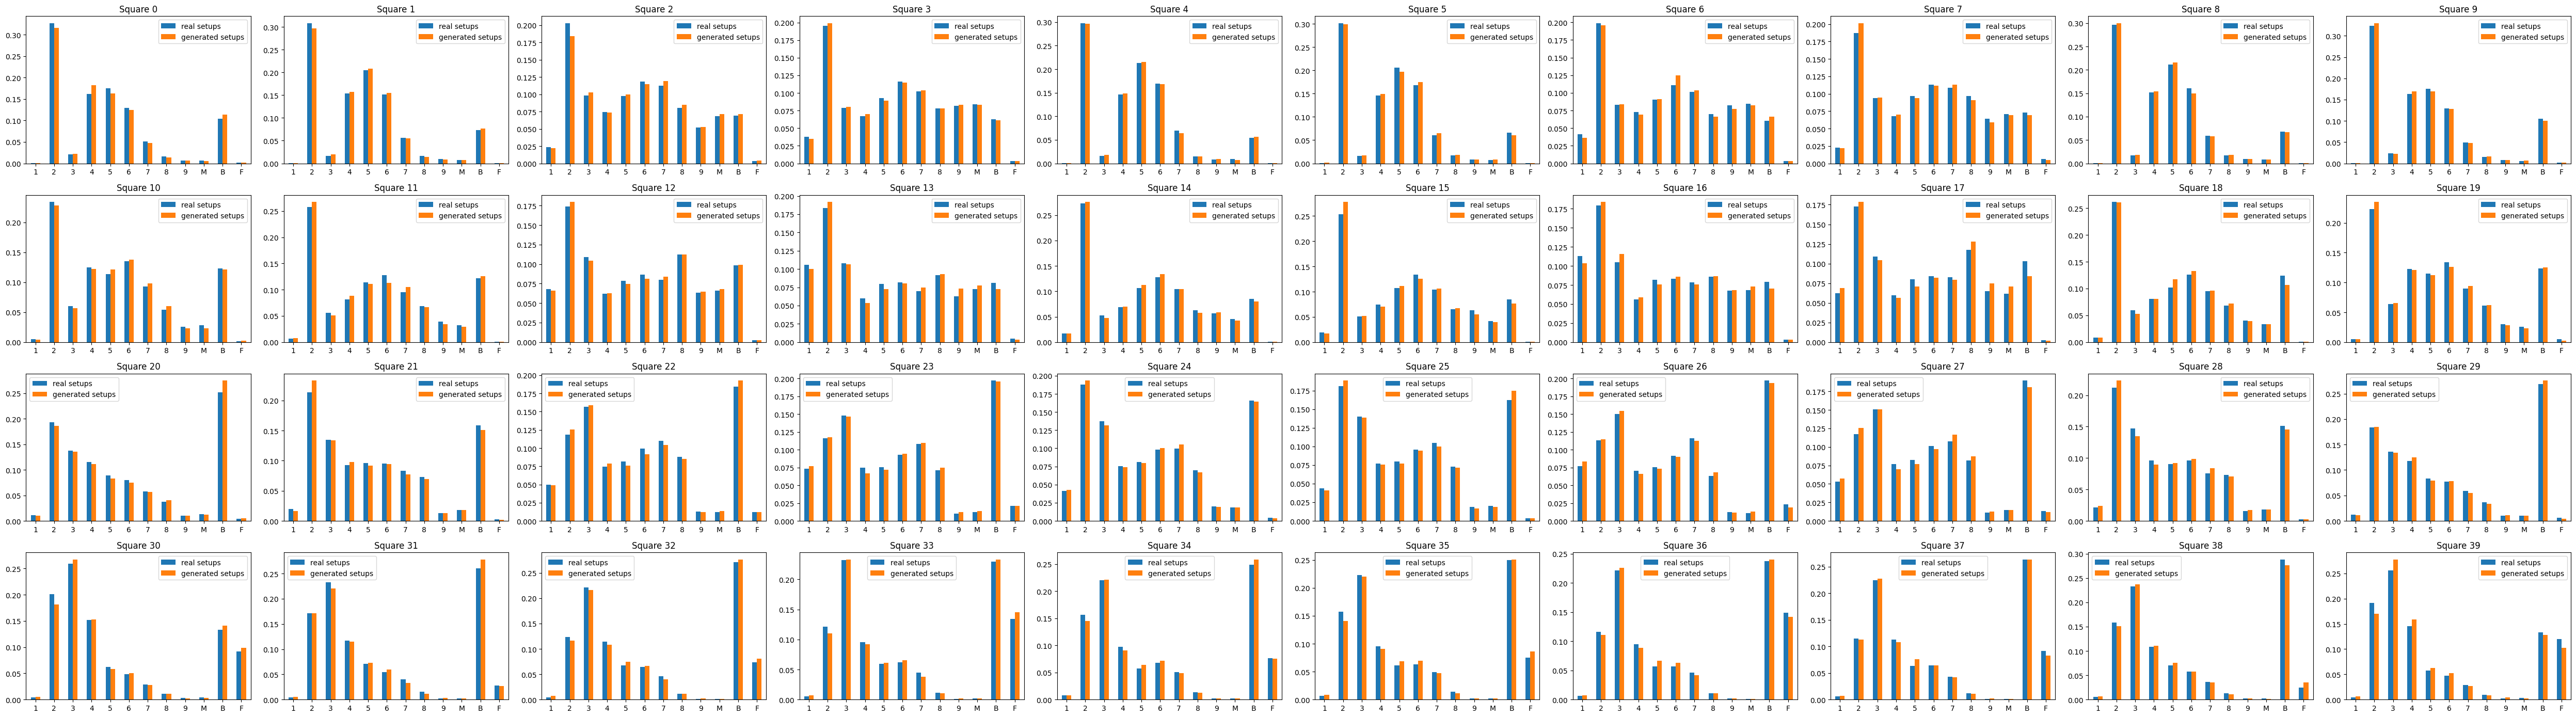

In [ ]:
plot_per_square_distributions(real_setups_df, generated_setups_df)

## Compute the most similar real setup for each generated setup

For each generated setup we compute the most similar real setup and the number of piece overlaps with that setup, making sure that our model is not memorizing setups.

In [ ]:
nearest_neighbors, max_overlaps = compute_nearest_neighbors(generated_setups_df.to_numpy(), real_setups_df.to_numpy())

<BarContainer object of 41 artists>

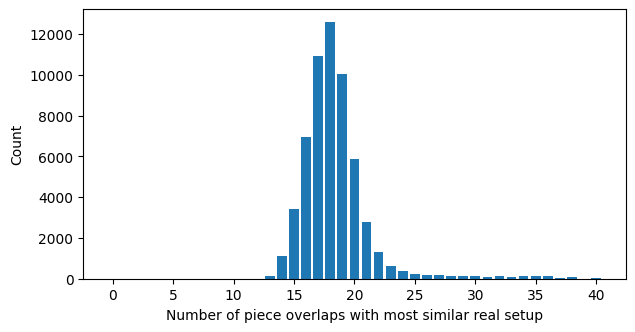

In [ ]:
plt.figure(figsize=(7, 3.5))
plt.xlabel("Number of piece overlaps with most similar real setup")
plt.ylabel("Count")
plt.bar(range(41), [sum(max_overlaps == n) for n in range(41)])

## Adversarial validation

We train a classifier to distinguish between real and generated setups. AUC scores near 0.5 indicate that the distribution of generated setups closely matches the distribution of the real setups.

In [ ]:
real_setups_df['label'] = 1
generated_setups_df['label'] = 0
classification_df = pd.concat([generated_setups_df, real_setups_df])
X = classification_df.drop(columns='label')
y = classification_df['label']

In [ ]:
classification_dataset = create_classification_dataset(X, y)

In [ ]:
criterion =  nn.BCEWithLogitsLoss()
num_epochs = 30
batch_size = 128

classifier_params = {"hidden_size": 256, "embedding_dim": 8, "num_layers": 2}

num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

In [ ]:
torch.manual_seed(SEED)

training_history = []

for fold_number, (train_indices, val_indices) in enumerate(kfold.split(X, y)):

    print(f"fold {fold_number + 1}")

    classifier = LSTMClassifier(**classifier_params)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    train_dataloader = DataLoader(Subset(classification_dataset, train_indices), batch_size=batch_size, shuffle=True,
                                  generator=torch.Generator().manual_seed(SEED))
    val_dataloader = DataLoader(Subset(classification_dataset, val_indices), batch_size=batch_size, shuffle=False)

    metrics_per_epoch = train(classifier, train_dataloader, num_epochs, optimizer, criterion,
                              val_dataloader, eval_metrics=[("Cross Entropy", binary_log_loss_from_logits), ("AUC", roc_auc_score)], )

    training_history.append(metrics_per_epoch)

fold 1
Using device 'cuda'
Epoch: 1, Train Cross Entropy: 0.68845, Train AUC: 0.5544, Val Cross Entropy: 0.68973, Val AUC: 0.54603
Epoch: 2, Train Cross Entropy: 0.68674, Train AUC: 0.56638, Val Cross Entropy: 0.68839, Val AUC: 0.55596
Epoch: 3, Train Cross Entropy: 0.68599, Train AUC: 0.57041, Val Cross Entropy: 0.68748, Val AUC: 0.56161
Epoch: 4, Train Cross Entropy: 0.68302, Train AUC: 0.58462, Val Cross Entropy: 0.68604, Val AUC: 0.5712
Epoch: 5, Train Cross Entropy: 0.67664, Train AUC: 0.60212, Val Cross Entropy: 0.68178, Val AUC: 0.58169
Epoch: 6, Train Cross Entropy: 0.66775, Train AUC: 0.62437, Val Cross Entropy: 0.67975, Val AUC: 0.59311
Epoch: 7, Train Cross Entropy: 0.65858, Train AUC: 0.6484, Val Cross Entropy: 0.67793, Val AUC: 0.59867
Epoch: 8, Train Cross Entropy: 0.64029, Train AUC: 0.68418, Val Cross Entropy: 0.67925, Val AUC: 0.60605
Epoch: 9, Train Cross Entropy: 0.61339, Train AUC: 0.725, Val Cross Entropy: 0.67778, Val AUC: 0.61589
Epoch: 10, Train Cross Entropy: 0

In [ ]:
for fold_history in training_history:
    print(max(fold_history['val_metrics']['AUC']))

0.6279240021679677
0.5905224902953559
0.6319708688876486
0.6322578963705376
0.6324421647935456


## Piece by piece setup generation

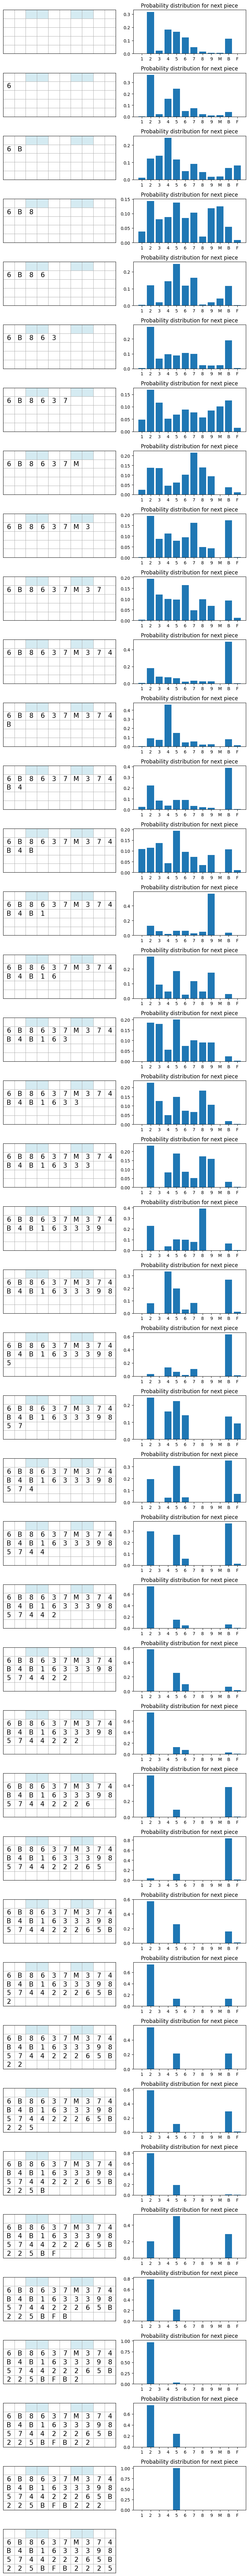

In [ ]:
setup_index = 0
plot_setup_generation(generated_setups[setup_index], distributions[setup_index])